In [1]:

import dcor
import dgl
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import seaborn as sns
from time import time
# from tqdm import tqdm
import torch
import warnings
import yfinance as yf

from utils import build_nx_graph, gen_q_dict_mis, qubo_dict_to_torch, \
    get_gnn, run_gnn_training, loss_func, postprocess_gnn_mis, run_mis_solver
from utils_backtest import portfolio_return, drawdown, sharpe_ratio, sortino_ratio, \
    max_drawdown, calmar_ratio
from utils_distance_correlation import df_distance_correlation

warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [2]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


## Read in Data

In [3]:
sp500_hist = pd.read_csv(
    "sp500_hist_prices.csv",
    parse_dates=['Date'],
    index_col='Date'
)

sp500_hist = sp500_hist.loc['2015-01-01':,]
sp500_hist.dropna(axis=1, inplace=True)


print(f'Shape: {sp500_hist.shape}')
sp500_hist.head()

Shape: (2014, 478)


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,37.823849,51.079903,146.459579,24.565695,46.113235,79.364059,38.241337,19.496668,77.119682,72.339996,...,129.637009,28.097225,63.720268,48.605167,34.251171,44.513111,102.393478,77.430000,23.814734,40.952682
2015-01-05,37.115143,51.051491,144.529114,23.873646,45.245419,78.688522,38.249859,19.379999,75.817574,71.980003,...,127.430634,27.778292,61.976727,48.268211,32.119461,43.608700,106.213135,76.339996,22.922415,40.706844
2015-01-06,36.536957,50.255581,144.427490,23.875891,45.021481,79.118393,37.815487,19.423332,75.270683,70.529999,...,124.712379,27.926092,61.647266,47.669205,31.930571,43.073429,105.312767,75.790001,22.046934,40.309696
2015-01-07,37.021870,50.227150,147.531052,24.210676,46.841084,80.697617,38.122097,19.536667,76.850571,71.110001,...,128.375000,28.167236,62.271912,48.904675,32.182419,44.500801,107.931953,77.720001,22.257389,41.141811
2015-01-08,38.131599,50.843037,148.824203,25.140913,47.330963,80.881851,38.905670,19.876667,78.022469,72.919998,...,129.919373,28.493950,63.308403,50.112080,32.425278,45.276012,109.077820,79.379997,22.568857,41.775345


### S&P500 as Benchmark

In [4]:
gspc = yf.download(
    tickers="^GSPC", 
    start=sp500_hist.index[0].strftime(format="%Y-%m-%d"), 
    end=sp500_hist.index[-1].strftime(format="%Y-%m-%d")
)['Adj Close']

gspc

[*********************100%***********************]  1 of 1 completed


Date
2015-01-02    2058.199951
2015-01-05    2020.579956
2015-01-06    2002.609985
2015-01-07    2025.900024
2015-01-08    2062.139893
                 ...     
2022-12-22    3822.389893
2022-12-23    3844.820068
2022-12-27    3829.250000
2022-12-28    3783.219971
2022-12-29    3849.280029
Name: Adj Close, Length: 2013, dtype: float64

In [5]:
TRAIN_START_DATE, TRAIN_END_DATE = "2009-01-01", "2019-01-01"
VAL_START_DATE, VAL_END_DATE = TRAIN_END_DATE, "2020-01-01"
TEST_START_DATE, TEST_END_DATE = VAL_END_DATE, "2022-12-30"

df_train = sp500_hist.loc[TRAIN_START_DATE:TRAIN_END_DATE,:]
df_val = sp500_hist.loc[VAL_START_DATE:VAL_END_DATE,:]
df_test = sp500_hist.loc[TEST_START_DATE:TEST_END_DATE,:]

gspc_train = gspc.loc[TRAIN_START_DATE:TRAIN_END_DATE]
gspc_val = gspc.loc[VAL_START_DATE:VAL_END_DATE]
gspc_test = gspc.loc[TEST_START_DATE:TEST_END_DATE]

print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

assert df_train.shape[1] == df_val.shape[1] and df_val.shape[1] == df_test.shape[1]
assert df_train.shape[0] == gspc_train.shape[0] 
assert df_val.shape[0] == gspc_val.shape[0]
assert df_test.shape[0] == gspc_test.shape[0] + 1


Train shape: (1006, 478)
Validation shape: (252, 478)
Test shape: (756, 478)


### Build correlation matrix

In [6]:
df_train=df_train.pct_change()
df_train.dropna(axis=0, inplace=True)
df_train

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018737,-0.000556,-0.013181,-0.028171,-0.018819,-0.008512,0.000223,-0.005984,-0.016884,-0.004976,...,-0.017020,-0.011351,-0.027362,-0.006933,-0.062238,-0.020318,0.037304,-0.014077,-0.037469,-0.006003
2015-01-06,-0.015578,-0.015590,-0.000703,0.000094,-0.004949,0.005463,-0.011356,0.002236,-0.007213,-0.020145,...,-0.021331,0.005321,-0.005316,-0.012410,-0.005881,-0.012274,-0.008477,-0.007205,-0.038193,-0.009756
2015-01-07,0.013272,-0.000566,0.021489,0.014022,0.040416,0.019960,0.008108,0.005835,0.020989,0.008223,...,0.029369,0.008635,0.010133,0.025918,0.007887,0.033138,0.024871,0.025465,0.009546,0.020643
2015-01-08,0.029975,0.012262,0.008765,0.038423,0.010458,0.002283,0.020554,0.017403,0.015249,0.025453,...,0.012030,0.011599,0.016645,0.024689,0.007546,0.017420,0.010617,0.021359,0.013994,0.015399
2015-01-09,-0.007337,-0.030563,-0.005090,0.001072,-0.027354,0.008786,-0.010508,-0.008720,-0.001112,-0.014811,...,0.012499,-0.012285,-0.001409,-0.014568,-0.018863,-0.001767,-0.014424,0.014613,-0.027975,0.001584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,-0.009796,-0.034438,-0.016445,-0.025874,-0.008950,-0.016949,-0.025420,-0.029354,-0.025729,-0.017433,...,-0.014988,-0.045187,-0.038315,-0.005330,-0.032472,-0.012707,-0.021634,-0.022906,-0.014081,-0.029383
2018-12-26,0.045795,0.086474,0.041029,0.070422,0.057985,0.032222,0.061928,0.045161,0.039949,0.086713,...,0.078470,0.019753,0.047779,0.048787,0.047084,0.034130,0.049265,0.067320,0.051935,0.045913
2018-12-27,0.014342,-0.007742,-0.002193,-0.006490,0.009771,0.006709,0.014507,0.023920,0.010071,0.009823,...,-0.011186,0.008540,0.004371,0.000485,0.016804,0.010779,-0.000688,0.018555,-0.001234,0.017004


In [7]:
df_corr = df_distance_correlation(df_train=df_train, stocks=df_train.columns.to_list())
df_corr.to_csv('./correlation_matrix_dcor.csv')

100%|██████████| 478/478 [03:13<00:00,  2.47it/s]


In [8]:
df_corr.isnull().values.any()

False

In [9]:
df_corr

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.0,0.364723,0.268978,0.430685,0.454788,0.329624,0.576548,0.317788,0.570738,0.523774,...,0.333557,0.141884,0.386995,0.436387,0.544704,0.415734,0.508249,0.460428,0.41352,0.519248
AAL,0.364723,1.0,0.239693,0.297091,0.232495,0.274373,0.34748,0.275106,0.325144,0.32556,...,0.236892,0.060041,0.170722,0.285465,0.312875,0.308253,0.302762,0.328099,0.334012,0.312954
AAP,0.268978,0.239693,1.0,0.225304,0.21919,0.233867,0.298622,0.233568,0.293858,0.239379,...,0.141721,0.114375,0.21435,0.244241,0.256766,0.294038,0.255606,0.242742,0.326236,0.247709
AAPL,0.430685,0.297091,0.225304,1.0,0.278002,0.242618,0.413822,0.246018,0.455895,0.482318,...,0.292142,0.117536,0.328944,0.308042,0.35661,0.35696,0.350215,0.391707,0.291789,0.36423
ABBV,0.454788,0.232495,0.21919,0.278002,1.0,0.371076,0.509868,0.22012,0.373409,0.337616,...,0.257192,0.150023,0.291591,0.354058,0.321878,0.294361,0.433889,0.31324,0.272586,0.480996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.415734,0.308253,0.294038,0.35696,0.294361,0.239259,0.411819,0.312901,0.443337,0.444478,...,0.260957,0.201876,0.310368,0.2953,0.396481,1.0,0.360166,0.338069,0.344828,0.391922
ZBH,0.508249,0.302762,0.255606,0.350215,0.433889,0.376736,0.571299,0.318591,0.461444,0.438323,...,0.272286,0.158951,0.345457,0.435734,0.419217,0.360166,1.0,0.347559,0.348936,0.450445
ZBRA,0.460428,0.328099,0.242742,0.391707,0.31324,0.260226,0.402715,0.237985,0.389177,0.41538,...,0.333745,0.073466,0.305551,0.267422,0.424831,0.338069,0.347559,1.0,0.345764,0.409142
ZION,0.41352,0.334012,0.326236,0.291789,0.272586,0.243819,0.374392,0.367148,0.387801,0.309992,...,0.243969,0.102693,0.367302,0.272384,0.429843,0.344828,0.348936,0.345764,1.0,0.309934


In [10]:
df_corr.quantile(0.5).mean()

0.314771653503646

In [11]:
STOCK_NAMES = df_corr.columns.values

## Build Graph

In [12]:
THRESHOLD = 0.4

nx_graph = build_nx_graph(
    df_corr=df_corr,
    threshold=THRESHOLD
)

# assert nx.is_connected(nx_graph), 'Graph is not connected. Try to lower the threshold'
assert (df_corr.where(df_corr >= THRESHOLD).count().sum() - len(df_corr)) / 2 == len(nx_graph.edges)

### Plot degree distribution

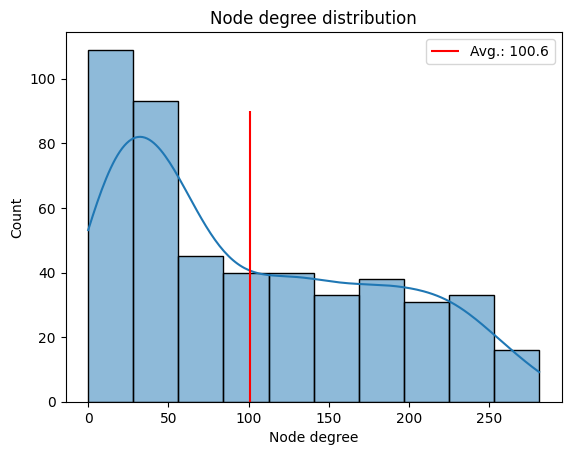

In [13]:
degrees = [degree for (node, degree) in nx_graph.degree()]
avg_degree = sum(degrees) / len(degrees)

sns.histplot(degrees, kde=True)
plt.vlines(avg_degree, ymin=0, ymax=90, colors=['r'], label=f"Avg.: {avg_degree:.1f}")
plt.title("Node degree distribution")
plt.xlabel("Node degree")
plt.legend()
plt.show()

In [14]:
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

gen_q_dict_mis(nx_graph)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(
    nx_graph, 
    gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

### Visualize graph

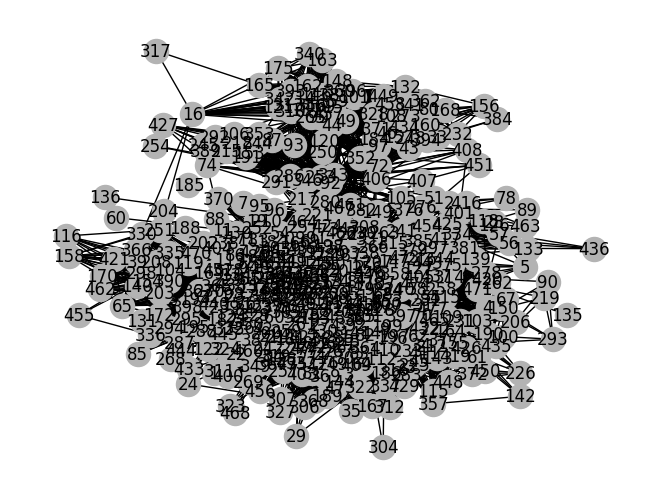

In [15]:
if len(nx_graph.nodes) < 500:
    pos = nx.kamada_kawai_layout(nx_graph)
    nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

## Set up GNN

In [16]:
# best set of parameters according to 
# hyperparameter tuning

params = {'lr': 0.0001,
 'dim_embedding': 22,
 'hidden_dim': 11,
 'dropout': 0.05,
 'number_classes': 1,
 'prob_threshold': 0.5,
 'number_epochs': 50000,
 'tolerance': 0.0001,
 'patience': 1000,
 'model': 'SAGE_2L_Model'}

In [17]:
n = len(nx_graph.nodes)

net, embed, optimizer = get_gnn(
    n_nodes=n,
    params=params, 
    model_type='SAGE_2L_Model', 
    torch_device=TORCH_DEVICE, 
    torch_dtype=TORCH_DTYPE
)

net

SAGE_2L_Model(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=22, out_features=22, bias=True)
    (fc_neigh): Linear(in_features=22, out_features=11, bias=False)
    (fc_self): Linear(in_features=22, out_features=11, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=11, out_features=11, bias=True)
    (fc_neigh): Linear(in_features=11, out_features=1, bias=False)
    (fc_self): Linear(in_features=11, out_features=1, bias=True)
  )
)

## Run GNN training

In [18]:
print('Running GNN...')
gnn_start = time()

net, embed, optimizer = get_gnn(
    n_nodes=n, 
    params=params, 
    model_type=params["model"], 
    torch_device=TORCH_DEVICE, 
    torch_dtype=TORCH_DTYPE)   
    
net, epoch, final_bitstring, best_bitstring, best_loss, inputs, loss_hist, epoch_hist = run_gnn_training(
    q_torch=q_torch, 
    dgl_graph=graph_dgl, 
    net=net, 
    embed=embed, 
    optimizer=optimizer, 
    number_epochs=params['number_epochs'],
    tol=params['tolerance'], 
    patience=params['patience'], 
    prob_threshold=params['prob_threshold'])

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: 1375.433837890625
Epoch: 1000, Loss: -14.568570137023926
Epoch: 2000, Loss: -25.18329429626465
Epoch: 3000, Loss: -30.33285140991211
Epoch: 4000, Loss: -35.32206344604492
Epoch: 5000, Loss: -37.78730392456055
Epoch: 6000, Loss: -42.7071418762207
Epoch: 7000, Loss: -48.84254455566406
Epoch: 8000, Loss: -54.12701416015625
Epoch: 9000, Loss: -59.301029205322266
Epoch: 10000, Loss: -68.50166320800781
Epoch: 11000, Loss: -68.1912612915039
Epoch: 12000, Loss: -68.54080963134766
Epoch: 13000, Loss: -70.9573974609375
Epoch: 14000, Loss: -71.93109893798828
Epoch: 15000, Loss: -71.9866943359375
Epoch: 16000, Loss: -71.98047637939453
Epoch: 17000, Loss: -71.99143981933594
Epoch: 18000, Loss: -71.99597930908203
Epoch: 19000, Loss: -71.99201965332031
Epoch: 20000, Loss: -71.99799346923828
Epoch: 21000, Loss: -71.86756896972656
Epoch: 22000, Loss: -71.99201965332031
Epoch: 23000, Loss: -71.99089050292969
Epoch: 24000, Loss: -71.99972534179688
Epoch: 25000, Loss: -71.99

## Post-process GNN Results

In [19]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN
size_mis_gnn, ind_set_gnn, number_violations_gnn = postprocess_gnn_mis(best_bitstring, nx_graph)
gnn_tot_time = time() - gnn_start

print(f'Independence number found by GNN is {size_mis_gnn} with {number_violations_gnn} violations')
print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

Calculating violations...
Independence number found by GNN is 72 with 0 violations
Took 552.707s, model training took 552.561s


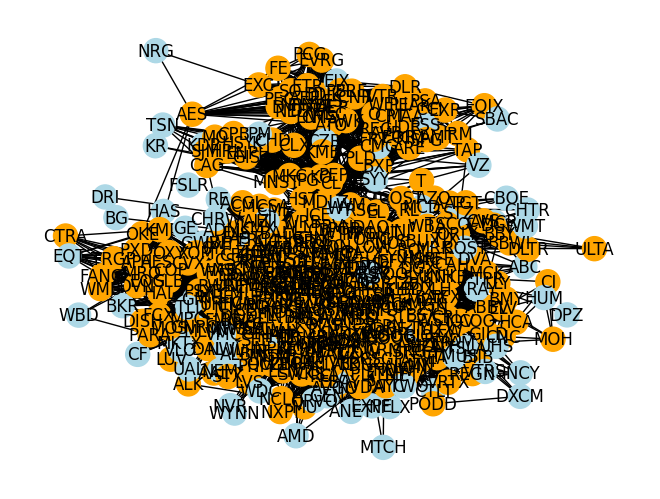

In [20]:
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map)

In [21]:
gnn_mis_set = STOCK_NAMES[np.argwhere(best_bitstring == 1)].tolist()[0]

## Compare against traditional solver

In [22]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, number_violations_nx, t_solve = run_mis_solver(nx_graph)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {number_violations_nx} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in MIS solver (n=478).
Calculating violations...
Independence number found by nx solver is 70 with 0 violations.
MIS solver took 4.468s


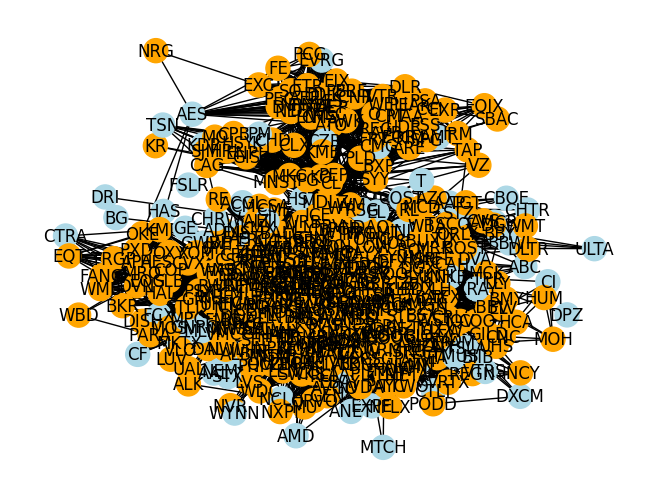

In [23]:
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map)

In [24]:
solver_mis_set = STOCK_NAMES[np.argwhere(torch.tensor(ind_set_bitstring_nx) == 1)].tolist()[0]

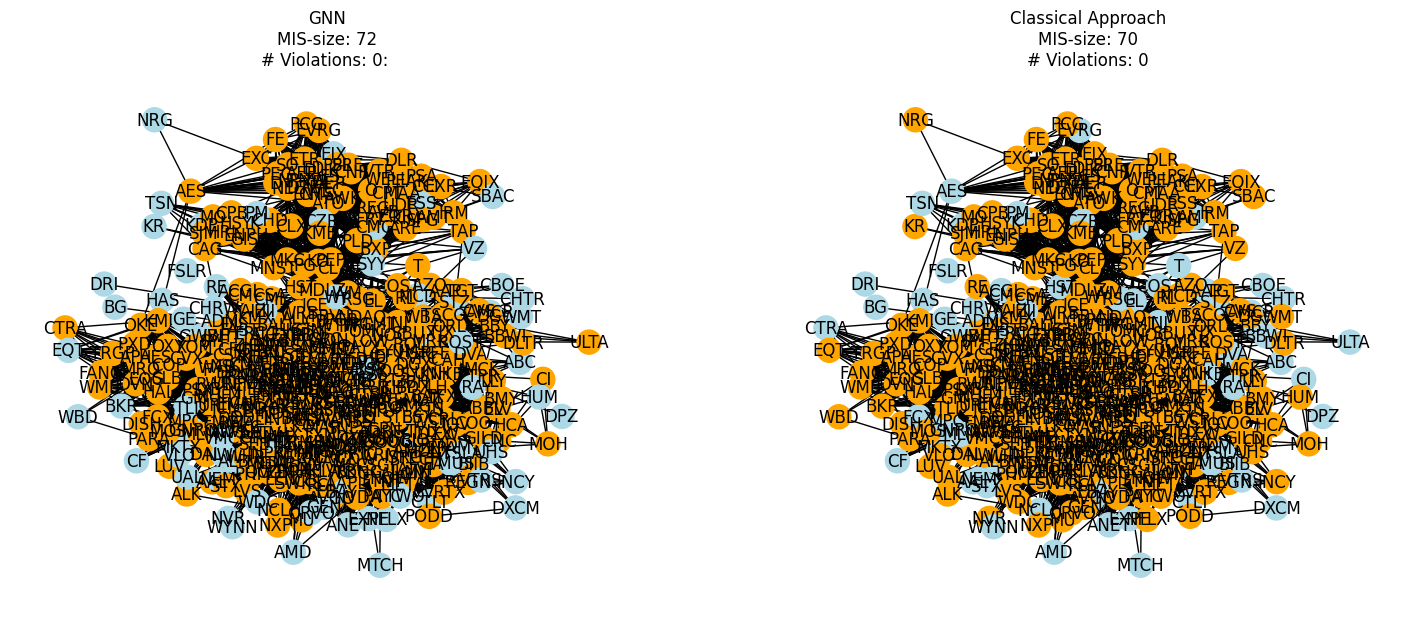

In [25]:
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

# GNN
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax0)
ax0.set_title(f"GNN\nMIS-size: {size_mis_gnn}\n# Violations: {number_violations_gnn}: ")

# MIS algo (classic approach)
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax1)
ax1.set_title(f"Classical Approach\nMIS-size: {ind_set_nx_size}\n# Violations: {number_violations_nx}")
plt.show()

In [26]:
df_mis = pd.concat([
    pd.DataFrame(
        data={'gnn': gnn_mis_set},
        index=gnn_mis_set
    ),
    pd.DataFrame(
        data={'solver': solver_mis_set},
        index=solver_mis_set
    )
],
axis=1)

df_mis

,gnn,solver
ABC,ABC,ABC
ALB,ALB,ALB
AMCR,AMCR,AMCR
AMD,AMD,AMD
ANET,ANET,ANET
...,...,...
NKE,NaN,NKE
RSG,NaN,RSG
STX,NaN,STX
T,NaN,T


In [27]:
# intersection
df_intersec = df_mis.dropna(axis=0)
print(f"Length: {len(df_intersec)}")
df_intersec

Length: 38


,gnn,solver
ABC,ABC,ABC
ALB,ALB,ALB
AMCR,AMCR,AMCR
AMD,AMD,AMD
ANET,ANET,ANET
BG,BG,BG
CBOE,CBOE,CBOE
CF,CF,CF
CHRW,CHRW,CHRW
CHTR,CHTR,CHTR


In [28]:
# Not intersecting
df_non_intersec = df_mis.drop(index=df_intersec.index)
print(f"Length: {len(df_non_intersec)}")
df_non_intersec

Length: 66


,gnn,solver
BIO,BIO,NaN
BKR,BKR,NaN
EIX,EIX,NaN
EQT,EQT,NaN
ESS,ESS,NaN
...,...,...
NKE,NaN,NKE
RSG,NaN,RSG
STX,NaN,STX
T,NaN,T


## Backtest

In [29]:
CAPITAL = 100_000

In [30]:
# #https://www.codearmo.com/blog/sharpe-sortino-and-calmar-ratios-python

# N_TRADING_DAYS = 252
# RISK_FREE_RATE = 0.01





In [31]:
def drawdown_pct(return_series):
    rs_max = return_series.rolling(
        window=len(return_series), 
        min_periods=1
        ).max()
    return return_series - rs_max

In [32]:
# def drawdown_pct(return_series):
#     rs_max = return_series.rolling(
#         window=len(return_series), 
#         min_periods=1
#         ).max()
#     return return_series - rs_max


# ppr = gnn_mis_returns_cum_val
# ppr_max = ppr.rolling(window=len(ppr), min_periods=1).max()
# ppr.plot()
# ppr_max.plot()
# plt.show()

In [33]:
# (ppr - ppr_max).plot()

In [34]:
# ppr.rolling(window=len(ppr), min_periods=1).max()

### Validation

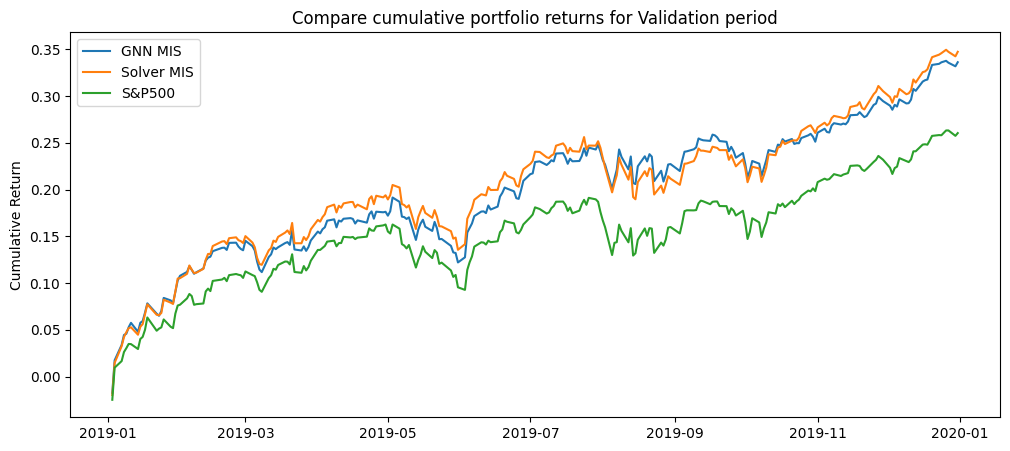

In [35]:
# GNN MIS Portfolio
gnn_mis_returns_val, gnn_mis_returns_cum_val = portfolio_return(
    df=df_val,
    assets=gnn_mis_set
)

# Solver MIS Portfolio
solver_mis_returns_val, solver_mis_returns_cum_val = portfolio_return(
    df=df_val,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_val = gspc_val.pct_change()
gspc_returns_cum_val = gspc_returns_val.cumsum()
# gspc_returns_cum_val_1 = ((gspc_val.pct_change() +1 ).cumprod()) -1


# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_returns_cum_val, label="GNN MIS")
plt.plot(solver_mis_returns_cum_val, label="Solver MIS")
plt.plot(gspc_returns_cum_val, label="S&P500")
# plt.plot(gspc_returns_cum_val_1, label="S&P500_1")


plt.title("Compare cumulative portfolio returns for Validation period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

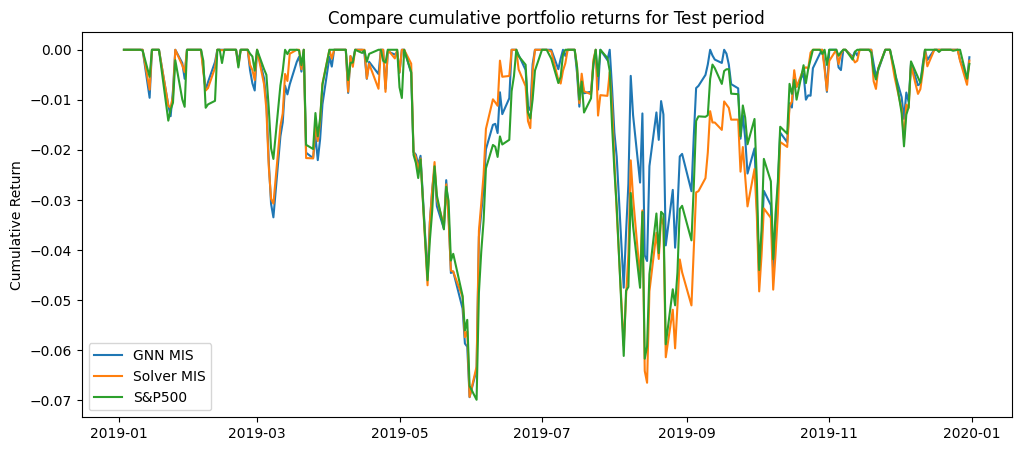

In [36]:
gnn_mis_mdd_val = drawdown_pct(gnn_mis_returns_cum_val)
solver_mis_mdd_val = drawdown_pct(solver_mis_returns_cum_val)
gspc_mdd_val = drawdown_pct(gspc_returns_cum_val)

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_mdd_val, label="GNN MIS")
plt.plot(solver_mis_mdd_val, label="Solver MIS")
plt.plot(gspc_mdd_val, label="S&P500")
plt.title("Compare cumulative portfolio returns for Test period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

In [37]:
# Sharpe Ratio
gnn_mis_sharpe_ratio = sharpe_ratio(return_series=gnn_mis_returns_val, N=252, rf=0.01)
solver_mis_sharpe_ratio = sharpe_ratio(return_series=solver_mis_returns_val, N=252, rf=0.01)
gspc_sharpe_ratio = sharpe_ratio(return_series=gspc_returns_val, N=252, rf=0.01)

print(f"GNN MIS sharpe ratio: {gnn_mis_sharpe_ratio:.2f}")
print(f"Solver MIS sharpe ratio: {solver_mis_sharpe_ratio:.2f}")
print(f"S&P500 sharpe ratio: {gspc_sharpe_ratio:.2f}\n")

# Sortino Ratio
gnn_mis_sortino_ratio = sortino_ratio(return_series=gnn_mis_returns_val, N=252, rf=0.01)
solver_mis_sortino_ratio = sortino_ratio(return_series=solver_mis_returns_val, N=252, rf=0.01)
gspc_sortino_ratio = sortino_ratio(return_series=gspc_returns_val, N=252, rf=0.01)

print(f"GNN MIS sortino ratio: {gnn_mis_sortino_ratio:.2f}")
print(f"Solver MIS sortino ratio: {solver_mis_sortino_ratio:.2f}")
print(f"S&P500 sortino ratio: {gspc_sortino_ratio:.2f}\n")

# Maximal drawdown
gnn_mis_mdd = max_drawdown(return_series=gnn_mis_returns_val)
solver_mis_mdd = max_drawdown(return_series=solver_mis_returns_val)
gspc_mdd = max_drawdown(return_series=gspc_returns_val)

print(f"GNN MIS MDD: {gnn_mis_mdd:.2f}")
print(f"Solver MIS MDD: {solver_mis_mdd:.2f}")
print(f"S&P500 MDD: {gspc_mdd:.2f}\n")

# Calmar ratio
gnn_mis_calmar_ratio = calmar_ratio(return_series=gnn_mis_returns_val, N=252, rf=0.01)
solver_mis_calmar_ratio = calmar_ratio(return_series=solver_mis_returns_val, N=252, rf=0.01)
gspc_calmar_ratio = calmar_ratio(return_series=gspc_returns_val, N=252, rf=0.01)

print(f"GNN MIS calmar ratio: {gnn_mis_calmar_ratio:.2f}")
print(f"Solver MIS calmar ratio: {solver_mis_calmar_ratio:.2f}")
print(f"S&P500 calmar ratio: {gspc_calmar_ratio:.2f}")


GNN MIS sharpe ratio: 2.56
Solver MIS sharpe ratio: 2.59
S&P500 sharpe ratio: 2.01

GNN MIS sortino ratio: 3.58
Solver MIS sortino ratio: 3.43
S&P500 sortino ratio: 2.49

GNN MIS MDD: -0.07
Solver MIS MDD: -0.07
S&P500 MDD: -0.07

GNN MIS calmar ratio: -4.83
Solver MIS calmar ratio: -4.99
S&P500 calmar ratio: -3.68


In [38]:
pd.DataFrame(
    data={
        "sharpe_gnn": [gnn_mis_sharpe_ratio],
        "sharpe_solver": [solver_mis_sharpe_ratio],
        "sharpe_SP500": [gspc_sharpe_ratio],
    },
    index=[2019]
)

,sharpe_gnn,sharpe_solver,sharpe_SP500
2019,2.562842,2.585751,2.011341


### Test

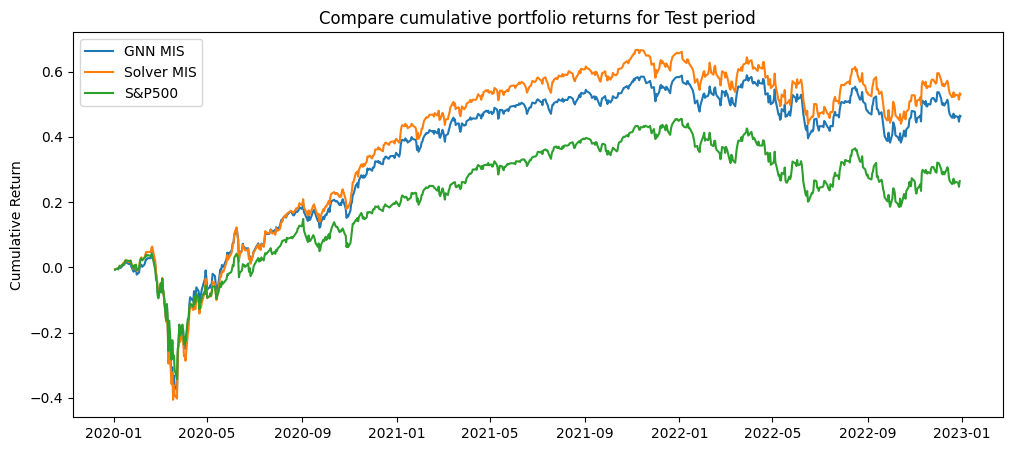

In [39]:
# GNN MIS Portfolio
gnn_mis_returns_test, gnn_mis_returns_cum_test = portfolio_return(
    df=df_test,
    assets=gnn_mis_set
)

# Solver MIS Portfolio
solver_mis_returns_test, solver_mis_returns_cum_test = portfolio_return(
    df=df_test,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_test = gspc_test.pct_change()
gspc_returns_cum_test = gspc_returns_test.cumsum()

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_returns_cum_test, label="GNN MIS")
plt.plot(solver_mis_returns_cum_test, label="Solver MIS")
plt.plot(gspc_returns_cum_test, label="S&P500")
plt.title("Compare cumulative portfolio returns for Test period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

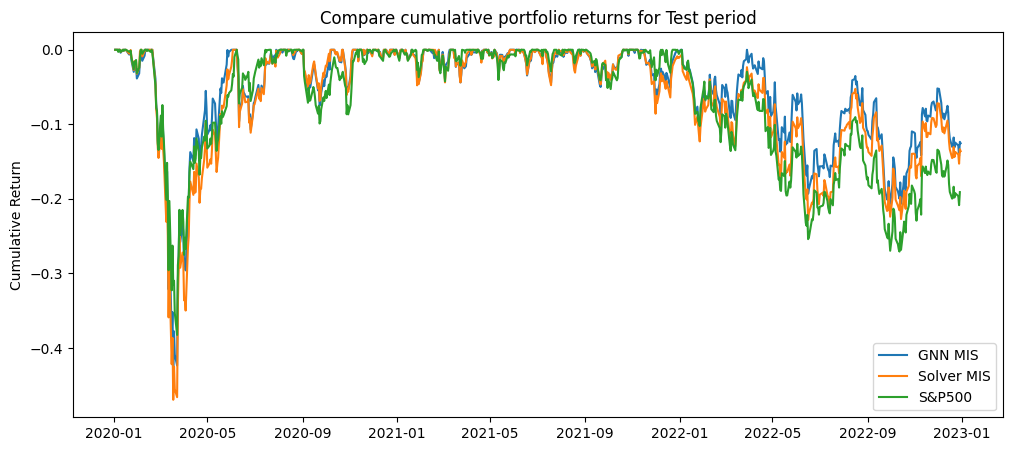

In [40]:
gnn_mis_mdd_test = drawdown_pct(gnn_mis_returns_cum_test)
solver_mis_mdd_test = drawdown_pct(solver_mis_returns_cum_test)
gspc_mdd_test = drawdown_pct(gspc_returns_cum_test)

# gnn_mis_mdd_val = drawdown(gnn_mis_returns_cum_val)
# solver_mis_mdd_val = drawdown(solver_mis_returns_cum_val)
# gspc_mdd_val = drawdown(gspc_returns_cum_val)


# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_mdd_test, label="GNN MIS")
plt.plot(solver_mis_mdd_test, label="Solver MIS")
plt.plot(gspc_mdd_test, label="S&P500")
# plt.hlines(0, xmin=gnn_mis_mdd_test.index[0], xmax=gnn_mis_mdd_test.index[-1])
plt.title("Compare cumulative portfolio returns for Test period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

In [41]:
# Sharpe Ratio
gnn_mis_sharpe_ratio = sharpe_ratio(return_series=gnn_mis_returns_test, N=252, rf=0.01)
solver_mis_sharpe_ratio = sharpe_ratio(return_series=solver_mis_returns_test, N=252, rf=0.01)
gspc_sharpe_ratio = sharpe_ratio(return_series=gspc_returns_test, N=252, rf=0.01)

print(f"GNN MIS sharpe ratio: {gnn_mis_sharpe_ratio:.2f}")
print(f"Solver MIS sharpe ratio: {solver_mis_sharpe_ratio:.2f}")
print(f"S&P500 sharpe ratio: {gspc_sharpe_ratio:.2f}\n")

# Sortino Ratio
gnn_mis_sortino_ratio = sortino_ratio(return_series=gnn_mis_returns_test, N=252, rf=0.01)
solver_mis_sortino_ratio = sortino_ratio(return_series=solver_mis_returns_test, N=252, rf=0.01)
gspc_sortino_ratio = sortino_ratio(return_series=gspc_returns_test, N=252, rf=0.01)

print(f"GNN MIS sortino ratio: {gnn_mis_sortino_ratio:.2f}")
print(f"Solver MIS sortino ratio: {solver_mis_sortino_ratio:.2f}")
print(f"S&P500 sortino ratio: {gspc_sortino_ratio:.2f}\n")

# Maximal drawdown
gnn_mis_mdd = max_drawdown(return_series=gnn_mis_returns_test)
solver_mis_mdd = max_drawdown(return_series=solver_mis_returns_test)
gspc_mdd = max_drawdown(return_series=gspc_returns_test)

print(f"GNN MIS MDD: {gnn_mis_mdd:.2f}")
print(f"Solver MIS MDD: {solver_mis_mdd:.2f}")
print(f"S&P500 MDD: {gspc_mdd:.2f}\n")

# Calmar ratio
gnn_mis_calmar_ratio = calmar_ratio(return_series=gnn_mis_returns_test, N=252, rf=0.01)
solver_mis_calmar_ratio = calmar_ratio(return_series=solver_mis_returns_test, N=252, rf=0.01)
gspc_calmar_ratio = calmar_ratio(return_series=gspc_returns_test, N=252, rf=0.01)

print(f"GNN MIS calmar ratio: {gnn_mis_calmar_ratio:.2f}")
print(f"Solver MIS calmar ratio: {solver_mis_calmar_ratio:.2f}")
print(f"S&P500 calmar ratio: {gspc_calmar_ratio:.2f}")


GNN MIS sharpe ratio: 0.55
Solver MIS sharpe ratio: 0.60
S&P500 sharpe ratio: 0.31

GNN MIS sortino ratio: 0.68
Solver MIS sortino ratio: 0.74
S&P500 sortino ratio: 0.38

GNN MIS MDD: -0.37
Solver MIS MDD: -0.39
S&P500 MDD: -0.34

GNN MIS calmar ratio: -0.39
Solver MIS calmar ratio: -0.42
S&P500 calmar ratio: -0.23
